In [ ]:
import definitions as df
import data_manipulation as dm
import norm_def as nd
import torch
import matplotlib.pyplot as plt
import model as md
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
total_size = 12000
max_x = 1000
max_y = 1000
min_x = 0
min_y = 0
track_len = 20

trajectories = dm.create_synthetic(total_size, max_x, max_y, min_x, min_y, track_len)

train_norm, test_norm = df.split_test_train(trajectories)
train, min_x, min_y, range_x, range_y = nd.normalize_data(train_norm)
test, min_x, min_y, range_x, range_y = nd.normalize_data(test_norm, min_x, min_y, range_x, range_y)
train_data, train_masked_point = df.mask_point_at_index(train, 6)
test_data, test_masked_point = df.mask_point_at_index(test, 6)

In [ ]:
x = nd.unnormalize_point((0.13, 0.14), min_x, min_y, range_x, range_y)
x

In [ ]:
src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(train_data, train_masked_point)

## DEBUG
print(src_data_tensor)
print("src_data_tensor shape:", src_data_tensor.shape)
print("tgt_data_tensor shape:", tgt_data_tensor.shape)
print("src_masks_tensor shape:", src_masks_tensor.shape)


input_dim = 2
hidden_dim = 64                                                                                   
output_dim = 2
rate = 0.0001

#model = md.SelfSupervisedModel(in_channels=3, out_channels=128, input_dim=128, model_dim=256, num_heads=8, num_layers=6, output_dim=3)
model = md.LSTMModel(2, 32, 2, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=rate) ## w
dataset = TensorDataset(src_data_tensor, tgt_data_tensor, src_masks_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


## TEMP
n_iters = 40
learning_rate = 0.001
batch_size = 32
threshold = 0.01

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
accuracy_values = []

for epoch in range(4):
    total_loss = 0
    model.train()  # Set the model to training mode
    for src, tgt, mask in dataloader:
        optimizer.zero_grad()
        output = model(src)
        masked_output = output  # output[:, 6, :]
        loss = loss_function(masked_output, tgt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{n_iters}, Loss: {avg_loss}')

    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        t_src_data_tensor, t_tgt_data_tensor, t_src_masks_tensor = df.prepare_data_for_transformer(test_data, test_masked_point)
        print(t_tgt_data_tensor[2])
        predictions = model(t_src_data_tensor)
        print(predictions[2])
        accuracy = df.compute_accuracy(predictions, t_tgt_data_tensor, threshold=0.13)
        print(accuracy)
        accuracy_values.append(accuracy)
        print(f'Accuracy after Epoch {epoch+1}/{n_iters}: {accuracy:.2f}%')

# Plotting loss and accuracy
epochs = range(1, 40 + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'r', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def predict_single_trajectory(model, trajectory):
    """
    Predicts the output for a single trajectory using the trained model.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        trajectory (any): The input trajectory data formatted as required by the model.
        device (str): The device to use ('cpu' or 'cuda').
    
    Returns:
        Any: The prediction made by the model.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(src_data_tensor)
    return predictions

In [79]:
trajectories = dm.create_synthetic(1, 1000, 1000, 0, 0, 20)
train, min_x, min_y, range_x, range_y = nd.normalize_data(trajectories, min_x, min_y, range_x, range_y)
train_data, train_masked_point = df.mask_point_at_index(train, 6)
src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(test_data, test_masked_point)
prediction = predict_single_trajectory(model, src_data_tensor)

hello


In [80]:
print("Data", src_data_tensor)
print("Prediction:", prediction)
print("red", src_masks_tensor)


Data tensor([[[0.2666, 0.7038],
         [0.2696, 0.7038],
         [0.2725, 0.7038],
         ...,
         [0.3161, 0.7038],
         [0.3190, 0.7038],
         [0.3219, 0.7038]],

        [[0.3263, 0.6936],
         [0.3299, 0.6939],
         [0.3336, 0.6942],
         ...,
         [0.3880, 0.6980],
         [0.3916, 0.6982],
         [0.3953, 0.6985]],

        [[0.6792, 0.4507],
         [0.6828, 0.4507],
         [0.6864, 0.4507],
         ...,
         [0.7410, 0.4507],
         [0.7446, 0.4507],
         [0.7483, 0.4507]],

        ...,

        [[0.5373, 0.1539],
         [0.5363, 0.1529],
         [0.5353, 0.1518],
         ...,
         [0.5201, 0.1361],
         [0.5191, 0.1351],
         [0.5181, 0.1340]],

        [[0.7170, 0.3423],
         [0.7235, 0.3423],
         [0.7301, 0.3423],
         ...,
         [0.8283, 0.3423],
         [0.8349, 0.3423],
         [0.8414, 0.3423]],

        [[0.1801, 0.5656],
         [0.1844, 0.5656],
         [0.1888, 0.5656],
         .

In [102]:
data = src_data_tensor.tolist()
bp = src_masks_tensor.tolist()
tg = tgt_data_tensor.tolist()
for i, (seq, mask_seq) in enumerate(zip(data, bp)):
    for j, mask in enumerate(mask_seq):
        if mask:
            if data[i][j] == [0.0, 0.0]:
                data[i][j] = list(prediction[i].tolist())

In [103]:
line = nd.unnormalize_points_list(data[300], min_x, min_y, range_x, range_y)

[974.0000215815494, 977.0000292469433, 980.0000369123372, 982.9999626506008, 985.9999703159947, 988.9999779813886, 981.3429864358268, 994.9999933121765, 998.0000009775704, 1001.0000086429643, 1004.0000163083582, 1007.0000239737524, 1010.0000316391463, 1013.0000393045402, 1015.9999650428035, 1018.9999727081974, 1021.9999803735916, 1024.9999880389855, 1027.9999957043794, 1031.0000033697734] [659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 672.5598672911416, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685, 659.0000134139685]


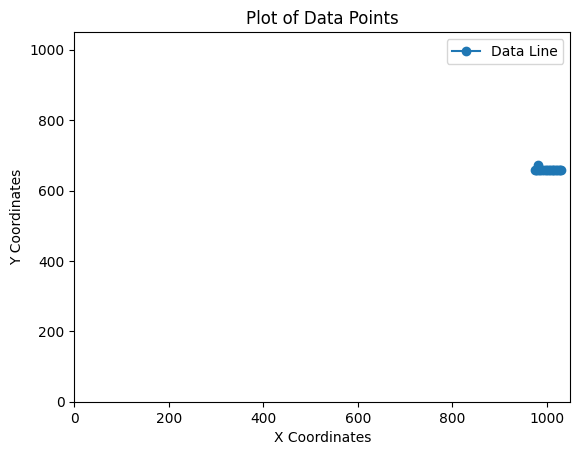

In [104]:
x = [point[0] for point in line]
y = [point[1] for point in line]
print(x, y)
fig, ax = plt.subplots()
ax.plot(x, y, label='Data Line', marker='o')
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
ax.set_title('Plot of Data Points')
ax.legend()
ax.set_xlim([0, 1050])
ax.set_ylim([0, 1050])
plt.show()

In [167]:
def calculate_accuracy_with_tolerance(data, tg, bp, tolerance=10):
    """
    Calculate the accuracy of predictions in data against the target (tg),
    only considering the positions marked as True in the blueprint (bp).
    A prediction is considered correct if it is within 'tolerance' of the target.

    Parameters:
        data (list of lists): The predicted data with predictions injected at masked positions.
        tg (list of lists): The target data to compare against, corresponding only to True mask positions.
        bp (list of lists of bool): Mask indicating where predictions were injected.
        tolerance (float): The tolerance level within which predictions are considered correct.

    Returns:
        float: The accuracy as a percentage of correct predictions.
    """
    correct = 0
    total = 0

    for i, (seq, mask_seq, target_seq) in enumerate(zip(data, bp, tg)):
        target_index = 0
        for j, (mask, pred) in enumerate(zip(mask_seq, seq)):
            if mask:
                if target_index < len(target_seq):
                    target = target_seq
                    total += 1
                    print(pred[0], target[0])
                    break
                    if abs(pred[0] - target[0]) <= tolerance and abs(pred[1] - target[1]) <= tolerance:
                        correct += 1
                    target_index += 1
                else:
                    print("Warning")
    if total == 0:
        return 0  # Avoid division by zero
    accuracy = (correct / total) * 100
    return accuracy

In [168]:
data = src_data_tensor.tolist()
bp = src_masks_tensor.tolist()
tg = tgt_data_tensor.tolist()
data = nd.unnormalize_data(data, min_x, min_y, range_x, range_y)
tg = nd.unnormalize_points_list(tg, min_x, min_y, range_x, range_y)
for i, (seq, mask_seq) in enumerate(zip(data, bp)):
    for j, mask in enumerate(mask_seq):
        if mask:
            if data[i][j] == [0.0, 0.0]:
                data[i][j] = list(prediction[i].tolist())
acc = calculate_accuracy_with_tolerance(data, tg, bp)
print("Accuracy:", acc)

-184.509165 205.9999845282657
-184.509165 293.9269255615711
-184.509165 779.0000148937258
-184.509165 137.99999511537993
-184.509165 583.0000056507708
-184.509165 890.9417231701111
-184.509165 113.99999523757623
-184.509165 164.0000001034462
-184.509165 596.2523744294806
-184.509165 463.99998833510114
-184.509165 966.8090315543873
-184.509165 77.00000310663069
-184.509165 948.0000370752657
-184.509165 910.5395939890132
-184.509165 519.0000059766278
-184.509165 616.0000080429738
-184.509165 610.7279152668591
-184.509165 58.99999807783223
-184.509165 774.9297931223446
-184.509165 511.20447565335604
-184.509165 671.9999872760666
-184.509165 915.0000346830627
-184.509165 257.9999945043984
-184.509165 646.0000027697829
-184.509165 414.196157983262
-184.509165 92.00000047003516
-184.509165 0.9366021354541942
-184.509165 989.6709611803501
-184.509165 665.9999719452785
-184.509165 673.3140165224822
-184.509165 408.0000091020085
-184.509165 509.99998298044585
-184.509165 899.9999963560931
-184.